This notebook applies hierarchical bayesian modeling using three variables: precipitation and distance to water bodies, and soil characteristics

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import tqdm
import theano.tensor as tt
import scipy.stats as stats 

import geopandas as gpd
from scripts import *
tqdm.pandas()

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Pre-Processing

In [2]:
df, basin_idx, basins, coords = read_data(file_dir='../data/hierarchical_septics_v2.csv',
                                          cols=['sewageSystem', 'ppt_2013', 'water_dist', 'gSSURGO_GA'],
                                          is_balanced=True)

balancing...
repairs: 11.054594777890811%, non-repairs: 88.94540522210919%


In [3]:
# soil information (in in/h), normalized
soil_dict = {
    'A': 6.00,
    'B': 3.50,
    'C': 0.78,
    'D': 0.14
}

df['hydraulic_c'] = df['gSSURGO_GA'].str[0] # get the first value if a system has more than one soil type
df['hydraulic_c'] = df['hydraulic_c'].replace(soil_dict)
df['hydraulic_c_norm'] = (df['hydraulic_c'] - df['hydraulic_c'].min()) / (df['hydraulic_c'].max() - df['hydraulic_c'].min())

# Hierarchical Bayesian Model

- Group septic systems based on their basin (~1560 basins)
- The effect of precipitation, distance to water bodies, and soil characteristic to septic's status

## Empirical Distributions
Empirical analysis for distance to water bodies and precipitation are done in the previous notebook: `01 hierarchical_bayesian_twovars`

### a) Soil Hydraulic Conductivity

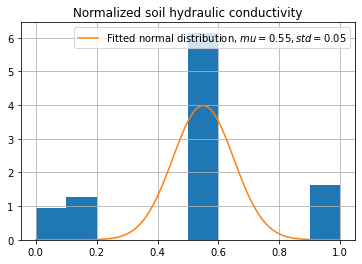

In [5]:
# plotting distribution (using Gamma distribution with alpha=1 or exponential decay)
x = np.linspace(0,1,100)
y = stats.norm.pdf(x, loc=0.55, scale=0.1)
df['hydraulic_c_norm'].hist(density=True)
plt.plot(x,y, label="Fitted normal distribution, $mu=0.55, std=0.05$")
plt.title("Normalized soil hydraulic conductivity")
plt.legend()

## Water Distance, Precipitation, and Hydraulics on Sewage Status $Y$

The full hierarchical bayesian formula is as follows:
$$
Y_{k} \sim Bernoulli(\theta_{k})\\
\theta_{k} = \sigma(\beta_{0,k} + \beta_{w,k} * waterdist + \beta_{p,k} * precip + \beta_{h_k})\\
\textbf{Intercept parameters}\\
\beta_{0,k} \sim N_{0,k}(\mu=\mu_{0}, \sigma=\theta_{0})\\
\mu_{0} \sim HN_0(\sigma=10), \quad \theta_{0} \sim HN_0(\sigma=10)\\
\textbf{Water distance parameters}\\
\beta_{w,k} \sim \Gamma_{w,k}(\alpha=\alpha_w, \beta=\beta_w)\\
\alpha_w \sim HN_w(\sigma=1), \quad \beta_w \sim HN_w(\sigma=5)\\
\textbf{Precipitation parameters}\\
\beta_{p,k} \sim HN_{p,k}(\sigma=\sigma_p)\\
\sigma_p \sim HN_p(\sigma=10)\\
\textbf{Hydraulics parameters}\\
\beta_{h,k} \sim U_{h,k}(lower=0,upper=\sigma_h)\\
\sigma_h \sim HN_h(\sigma=10)\\
\text{the subscript $w$, $p$, and $h$ denote distance to water bodies, precipitation, and hydraulics respectively, at the $k$-th basin}\\
\text{$\sigma$ (inverse logistic) function returns the binary value of 0 (repair) or 1 (new/addition)}
$$

In [35]:
# Modeling
with pm.Model(coords=coords) as model:
    # constant data: basin information and variables
    basin = pm.Data('basin', basin_idx, dims='septic')
    water_d = pm.Data('water_d', df.water_dist_norm.values, dims='septic')
    ppt_d = pm.Data('ppt_d', df.ppt_2013_norm.values, dims='septic')
    hydr_d = pm.Data('hydr_d', df.hydraulic_c_norm.values, dims='septic')

    # global model parameters
    wtr_alpha = pm.HalfNormal('wtr_alpha', sigma=1.)
    wtr_beta = pm.HalfNormal('wtr_beta', sigma=5)
    ppt_mu = pm.HalfNormal('ppt_mu', sigma=10)
    ppt_sig = pm.HalfNormal('ppt_sig', sigma=10)
    hydr_sig = pm.HalfNormal('hydr_sig', sigma=10)
    mu_c = pm.HalfNormal('mu_c', sigma=10)
    sigma_c = pm.HalfNormal('sigma_c', sigma=10)

    # septic-specific model parameters
    wtr_dist = pm.Gamma('wtr_dist', alpha=wtr_alpha, beta=wtr_beta, dims='basin')
    ppt = pm.HalfNormal('ppt', sigma=ppt_sig, dims='basin')
    hydr = pm.Uniform('hydr', lower=0, upper=hydr_sig, dims='basin')
    c = pm.Normal('c', mu=mu_c, sigma=sigma_c, dims='basin')
    
    # hierarchical bayesian formula
    failure_theta = pm.math.sigmoid(c[basin_idx] 
                                    + wtr_dist[basin_idx] * water_d 
                                    + ppt[basin_idx] * ppt_d
                                    + hydr[basin_idx] * hydr_d
                                   )

    # likelihood of observed data
    failures = pm.Bernoulli('failures', failure_theta, observed=df['sewageSystem_enc'])
    
    # fitting using NUTS sampler
    trace = pm.sample(500, tune=200, cores=4, return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, hydr, ppt, wtr_dist, sigma_c, mu_c, hydr_sig, ppt_sig, ppt_mu, wtr_beta, wtr_alpha]


Sampling 4 chains for 200 tune and 500 draw iterations (800 + 2_000 draws total) took 112 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'wtr_dist'}>,
        <AxesSubplot:title={'center':'wtr_dist'}>],
       [<AxesSubplot:title={'center':'ppt'}>,
        <AxesSubplot:title={'center':'ppt'}>],
       [<AxesSubplot:title={'center':'hydr'}>,
        <AxesSubplot:title={'center':'hydr'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>]], dtype=object)

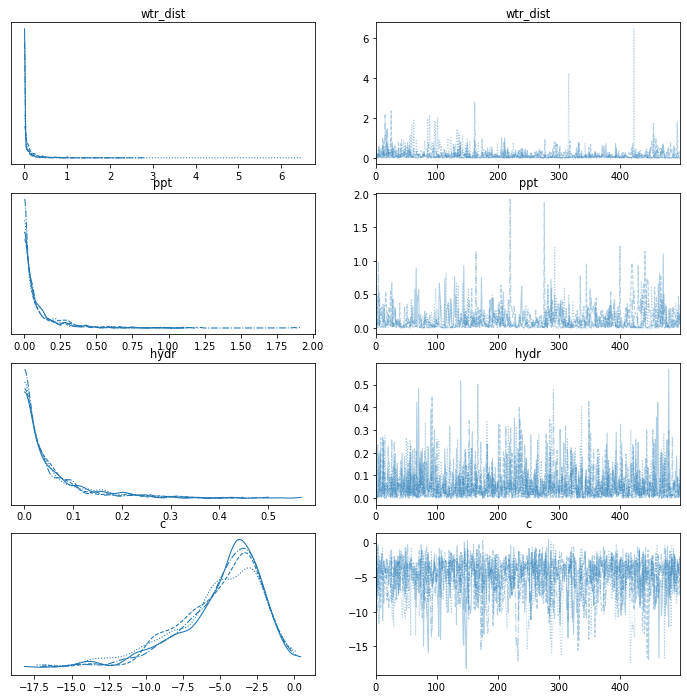

In [36]:
# get sample basin for analysis
sample_coords = {'basin': df.HU_12_NAME[:2].values}

# analyze the posterior distribution (fitted parameters)
az.plot_trace(trace, var_names=['wtr_dist', 'ppt', 'hydr', 'c'], coords=sample_coords, figsize=(12,12), compact=True)

In [37]:
# evaluate model
y = df.sewageSystem_enc.to_list()
acc = evaluate_bayes(trace, model, y)
print(f'accuracy is: {acc}%')

/home/user/anaconda3/envs/sentinel/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


accuracy is: 90.33742331288343%
